In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define Standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [23]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [24]:
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [25]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [26]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [28]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In [29]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


In [30]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype("uint8")
    return torch.from_numpy(subsequent_mask) == 0

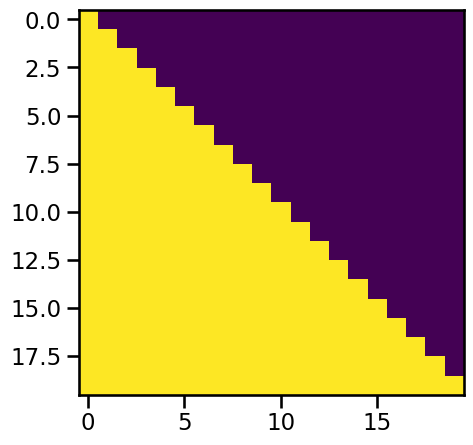

In [31]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [32]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [89]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        x, self_attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)

In [90]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [91]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [92]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(1, d_model, 2) * -(math.log(1000.0)/d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

In [93]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):

    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)

    return model

In [94]:
tmp_model = make_model(10, 10, 2)

<ipython-input-93-c6ca7eda0a2e>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [95]:
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

In [96]:
class Batch:
    "Object for holding a batchof data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [107]:
def run_epoch(data_iter, model, loss_compute):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0

    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)

        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %(i, loss/batch.ntokens, tokens/elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [108]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding"
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0

    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [109]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate."
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p["lr"] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step

        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

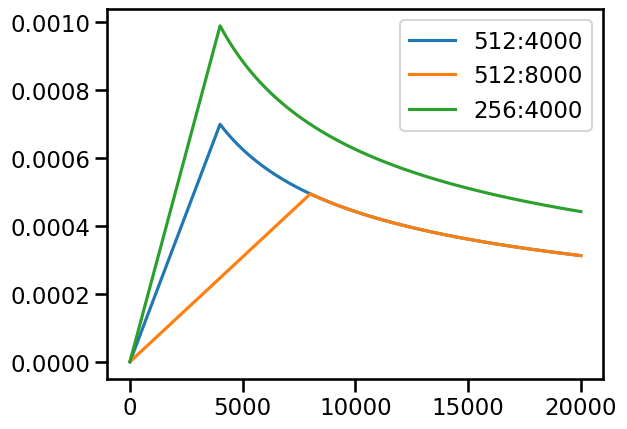

In [110]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [111]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size

        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)

        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


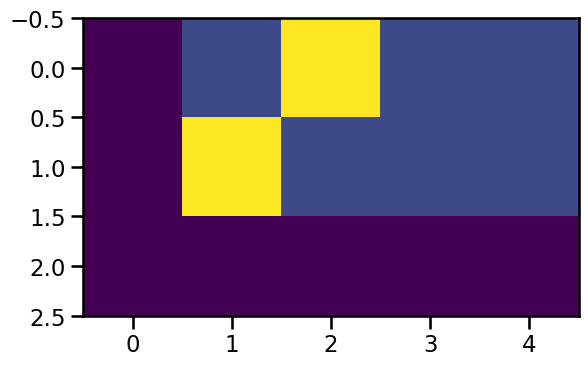

In [112]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))
plt.imshow(crit.true_dist)

In [113]:
crit = LabelSmoothing(5, 0, 0.4)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],])
    print(predict.log())
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1])))
print(loss(2))
# plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

tensor([[   -inf, -0.9163, -1.6094, -1.6094, -1.6094]])
tensor(nan)


In [114]:
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [117]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()

        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [118]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
<ipython-input-93-c6ca7eda0a2e>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.293911 Tokens per Sec: 259.739441
Epoch Step: 1 Loss: 1.901954 Tokens per Sec: 407.887695
tensor(1.8826)
Epoch Step: 1 Loss: 2.061423 Tokens per Sec: 363.879181
Epoch Step: 1 Loss: 1.561617 Tokens per Sec: 450.265961
tensor(1.5931)
Epoch Step: 1 Loss: 1.819549 Tokens per Sec: 377.817322
Epoch Step: 1 Loss: 1.182400 Tokens per Sec: 306.407135
tensor(1.1744)
Epoch Step: 1 Loss: 1.597842 Tokens per Sec: 376.690460
Epoch Step: 1 Loss: 0.875450 Tokens per Sec: 454.290558
tensor(0.8597)
Epoch Step: 1 Loss: 1.210580 Tokens per Sec: 369.206543
Epoch Step: 1 Loss: 0.623542 Tokens per Sec: 361.643738
tensor(0.5603)
Epoch Step: 1 Loss: 0.703744 Tokens per Sec: 372.795654
Epoch Step: 1 Loss: 0.315908 Tokens per Sec: 464.590302
tensor(0.3232)
Epoch Step: 1 Loss: 0.515052 Tokens per Sec: 374.094574
Epoch Step: 1 Loss: 0.094312 Tokens per Sec: 451.780731
tensor(0.1570)
Epoch Step: 1 Loss: 0.415430 Tokens per Sec: 283.968018
Epoch Step: 1 Loss: 0.096999 Tokens per Sec: 451.716064

In [119]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)

    for i in range(max_len - 1):
        out = model.decode(memory, src_mask, Variable(ys), Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10,start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


In [127]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 32.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
!pip install --upgrade torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 603.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install portalocker

In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k

# Define the source and target language tokenizers.
tokenize_de = get_tokenizer('spacy', language='de')
tokenize_en = get_tokenizer('spacy', language='en')

# Define the source and target vocabularies.
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Define a function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    if language == SRC_LANGUAGE:
        return (tokenize_de(example) for _, example in data_iter)
    else:
        return (tokenize_en(example) for example, _ in data_iter)

# Load the training data.
train_data, valid_data, test_data = Multi30k()

# Build the vocabularies.
src_vocab = build_vocab_from_iterator(yield_tokens(train_data, SRC_LANGUAGE))
tgt_vocab = build_vocab_from_iterator(yield_tokens(train_data, TGT_LANGUAGE))


/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'Lock'
This exception is thrown by __iter__ of _MemoryCellIterDataPipe(remember_elements=1000, source_datapipe=_ChildDataPipe)